In [3]:
import os
import re
import json
import pickle 
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import torch
import torchvision
import torchvision.transforms.functional as TF
import tifffile
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram
from einops import rearrange, repeat
from ome_types import from_xml
from pydantic_extra_types.color import Color

In [4]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

In [7]:
import mushroom.utils as utils
import mushroom.data.xenium as xenium
import mushroom.data.multiplex as multiplex
import mushroom.visualization.tiling_utils as tiling_utils

In [8]:
save_dir = Path('/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/xenium_aux')
save_dir.mkdir(parents=True, exist_ok=True)

## save tiled

In [9]:
fps = """/diskmnt/primary/Xenium/data/20230830__153957__20230830_24001/output-XETG00122__0011120__S18-15142Fp1Us1_1__20230830__154053
/diskmnt/primary/Xenium/data//20231003__221302__24005/output-XETG00122__0010817__S18-11798-A15Us1_1__20231003__221400
/diskmnt/primary/Xenium/data//20231003__221302__24005/output-XETG00122__0010587__S18-15142-B17Us2_1__20231003__221400
/diskmnt/primary/Xenium/data//20231003__221302__24005/output-XETG00122__0010817__S18-18215-A25Us1_1__20231003__221400
/diskmnt/primary/Xenium/data//20231003__221302__24005/output-XETG00122__0010587__S18-5591-C8Us1_1__20231003__221400
/diskmnt/primary/Xenium/data/20231026__203216__24008/output-XETG00122__0011002__S18-9251-F15U1__20231026__203324
/diskmnt/primary/Xenium/data/20231026__203216__24008/output-XETG00122__0011010__S18-9259-B14U1__20231026__203324
/diskmnt/primary/Xenium/data/20231026__203216__24008/output-XETG00122__0011002__S19-41530-D1U3__20231026__203324
/diskmnt/primary/Xenium/data/20231026__203216__24008/output-XETG00122__0011010__S21-11816-A2U3__20231026__203324
/diskmnt/primary/Xenium/data/20231026__203216__24008/output-XETG00122__0011010__S21-44455-A1U3__20231026__203324
/diskmnt/primary/Xenium/data/20231026__203216__24008/output-XETG00122__0011002__S22-53426-A1U3__20231026__203324
/diskmnt/primary/Xenium/data/20240228__230055__20240228_Prostate_Bone/output-XETG00122__0009954__HT814Z1-S1H1Fp1Us1_3__20240228__230117
/diskmnt/primary/Xenium/data/20240228__230055__20240228_Prostate_Bone/output-XETG00122__0009954__HT817Z1-S1H1Fp1Us1_2__20240228__230117
/diskmnt/primary/Xenium/data/20240228__230055__20240228_Prostate_Bone/output-XETG00122__0009954__S18-8795-A10Us2_1__20240228__230117
/diskmnt/primary/Xenium/data/20240320__161703__20240320_RCC_Prostate/output-XETG00122__0024817__HT832Z1-S1H1Fp1U1__20240320__161736
/diskmnt/primary/Xenium/data/20240322__175618__202040322_HTAN_SNP_prostate/output-XETG00122__0010300__S18-8122-B28U1__20240322__175655
/diskmnt/primary/Xenium/data/20240326__222642__20240326_Prostate_Chol/output-XETG00122__0024905__HT849Z1-S1H2Fp1U1__20240326__222724
/diskmnt/primary/Xenium/data/20240326__222642__20240326_Prostate_Chol/output-XETG00122__0024905__HT852Z1-S1H1Fp1U1__20240326__222724
/diskmnt/primary/Xenium/data/20240329__172043__20240329_pairedmCRC-CRC_prostate/output-XETG00122__0022749__S20-12521-A15U1__20240329__172116
/diskmnt/primary/Xenium/data/20240329__172043__20240329_pairedmCRC-CRC_prostate/output-XETG00122__0022750__S22-44238-A29U1__20240329__172116
/diskmnt/primary/Xenium/data/20240516__213831__20240516_HTAN_prostate/output-XETG00122__0033872__S18-5929-C27U2__20240516__213857
/diskmnt/primary/Xenium/data/20240516__213831__20240516_HTAN_prostate/output-XETG00122__0033871__S20-20021-B1U2__20240516__213856
/diskmnt/primary/Xenium/data/20240516__213831__20240516_HTAN_prostate/output-XETG00122__0033871__S23-26383-A1U2__20240516__213857
/diskmnt/primary/Xenium/data/20240516__213831__20240516_HTAN_prostate/output-XETG00122__0033871__S23-27043-A1U2__20240516__213857
/diskmnt/primary/Xenium/data/20240927__185207__20240927_5K_Multi_PCa_GBM_PKD/output-XETG00063__0037329__S18-8122-B28U1__20240927__185257
/diskmnt/primary/Xenium/data/20241010__203252__20241010_5K_MGI_PKD_PCa_PDAC_CRC/output-XETG00113__0037126__HT832Z1U1__20241010__203413
/diskmnt/primary/Xenium/data/20230803__195918__20230803_firstsamples/output-XETG00122__0010660__HT591B1-S1H1Fp1Us1_1__20230803__200008
/diskmnt/primary/Xenium/data/20240322__175618__202040322_HTAN_SNP_prostate/output-XETG00122__0010300__HT2681-Th1H3L1U2__20240322__175655
/diskmnt/primary/Xenium/data/20240322__175618__202040322_HTAN_SNP_prostate/output-XETG00122__0010297__HT268B1-Th1H3L1U1__20240322__175654
/diskmnt/primary/Xenium/data/20230803__195918__20230803_firstsamples/output-XETG00122__0010660__HT591B1-S1H1Fp1Us1_1__20230803__200008
/diskmnt/primary/Xenium/data/20241204_5K_MGI_PKD_BRC_CRC/output-XETG00113__0043724__1581620AU1__20241204__224100
/diskmnt/primary/Xenium/data/20241204_5K_MGI_PKD_BRC_CRC/output-XETG00113__0043724__1658952AU1__20241204__224100
/diskmnt/primary/Xenium/data/20241204_5K_MGI_PKD_BRC_CRC/output-XETG00113__0043724__1654977AU1__20241204__224100""".split('\n')


fps



['/diskmnt/primary/Xenium/data/20230830__153957__20230830_24001/output-XETG00122__0011120__S18-15142Fp1Us1_1__20230830__154053',
 '/diskmnt/primary/Xenium/data//20231003__221302__24005/output-XETG00122__0010817__S18-11798-A15Us1_1__20231003__221400',
 '/diskmnt/primary/Xenium/data//20231003__221302__24005/output-XETG00122__0010587__S18-15142-B17Us2_1__20231003__221400',
 '/diskmnt/primary/Xenium/data//20231003__221302__24005/output-XETG00122__0010817__S18-18215-A25Us1_1__20231003__221400',
 '/diskmnt/primary/Xenium/data//20231003__221302__24005/output-XETG00122__0010587__S18-5591-C8Us1_1__20231003__221400',
 '/diskmnt/primary/Xenium/data/20231026__203216__24008/output-XETG00122__0011002__S18-9251-F15U1__20231026__203324',
 '/diskmnt/primary/Xenium/data/20231026__203216__24008/output-XETG00122__0011010__S18-9259-B14U1__20231026__203324',
 '/diskmnt/primary/Xenium/data/20231026__203216__24008/output-XETG00122__0011002__S19-41530-D1U3__20231026__203324',
 '/diskmnt/primary/Xenium/data/202

In [10]:
import shutil

In [14]:
for fp in fps:
    name = fp.split('/')[-1]
    sid = name.split('__')[2]
    print(sid)

    transcripts_fp = Path(fp) / 'transcripts.parquet'
    assert os.path.exists(transcripts_fp)
    shutil.copy(transcripts_fp, save_dir / f'{sid}_transcripts.parquet')

S18-5929-C27U2
S20-20021-B1U2
S23-26383-A1U2
S23-27043-A1U2
S18-8122-B28U1
HT832Z1U1
HT591B1-S1H1Fp1Us1_1
HT2681-Th1H3L1U2
HT268B1-Th1H3L1U1
HT591B1-S1H1Fp1Us1_1
1581620AU1
1658952AU1
1654977AU1


In [10]:
tiling_size = 10

for fp in fps:
    name = fp.split('/')[-1]
    sid = name.split('__')[2]
    print(sid)
    adata = xenium.adata_from_xenium(fp)
    
    if adata.shape[1] < 2000:
        transcripts_fp = Path(fp) / 'transcripts.parquet'
        assert os.path.exists(transcripts_fp)
        transcripts = pd.read_parquet(transcripts_fp)

        img, tiled_channels = tiling_utils.tile_xenium(adata, tile_size=tiling_size, transcripts=transcripts)
    else:
        img = tiling_utils.tile_xenium(adata, tile_size=tiling_size)
        tiled_channels = adata.var.index.to_list()
        
    if img.dtype != np.uint8:
        img = img - img.min((0, 1), keepdims=True)
        img = img / img.max((0, 1), keepdims=True)
        img = img * 255
        img = img.astype(np.uint8)
    img = rearrange(img, 'h w c -> c h w')
    
    tifffile.imwrite(save_dir / f'{sid}_tiled.tif', img, compression='LZW')
    
    
    meta = {
        'channels': list(tiled_channels),
        'sid': sid
    }
    yaml.safe_dump(meta, open(save_dir / f'{sid}_metadata.yaml', 'w'))

HT832Z1U1


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


## save rgbs

In [9]:
XENIUM_FOCUS_SETTINGS = [
    {
        'channel': 'DAPI',
        'color': 'blue',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
    {
        'channel': 'ATP1A1/CD45/E-Cadherin',
        'color': 'magenta',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
                         {
        'channel': '18S',
        'color': 'yellow',
        'min_value': 0,
        'max_value': 50,
        'gamma': 1.
    },
                         {
        'channel': 'alphaSMA/Vimentin',
        'color': 'green',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
]

xenium_view_settings = [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
#         {
#             'channel': 'TP63',
#             'color': 'white',
#             'marker': 's',
#         },
#         {
#             'channel': 'KRT5',
#             'color': 'white',
#             'marker': 's',
#         },
#         {
#             'channel': 'KRT7',
#             'color': 'white',
#             'marker': 's',
#         },
#         {
#             'channel': 'KRT14',
#             'color': 'white',
#             'marker': 's',
#         },
        {
            'channel': 'ACTA2',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CP',
            'color': 'purple',
            'marker': 'P',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
]

def get_xenium_pseudo(morph_fp, focus_settings):
    cs = multiplex.get_ome_tiff_channels(morph_fp)
    if len(cs) == 1: # just nuclei
        channels = ['DAPI']
        colors = ['white']
        min_values = [0.]
        max_values = [100.]
        gammas = [1.]
    else: # multiple channels
        channels = [x['channel'] for x in focus_settings]
        colors = [x['color'] for x in focus_settings]
        min_values = [x['min_value'] for x in focus_settings]
        max_values = [x['max_value'] for x in focus_settings]
        gammas = [x['gamma'] for x in focus_settings]
    
    channel_to_img = multiplex.extract_ome_tiff(morph_fp, as_dict=True)
    data = np.stack([channel_to_img[x] for x in channels])
    
    rgb = multiplex.to_pseudocolor(
        data,
        colors=colors,
        min_values=min_values,
        max_values=max_values,
        gammas=gammas
    )
    
    rgb *= 255.
    rgb = rgb.astype(np.uint8)
    
    return rgb

def plot_xenium_pseudo(ax, rgb, transcripts, view_settings, s=.1):
    ax.imshow(rgb)
    
    if not isinstance(transcripts, pd.DataFrame):
        transcripts = pd.read_parquet(transcripts)
        
    pool = set(transcripts['feature_name'])
    for entry in view_settings:
        color = np.asarray(Color(entry['color']).as_rgb_tuple()) / 255.
        channel = entry['channel']
        marker = entry['marker']
        
        if channel in pool:
            small = transcripts[transcripts['feature_name']==channel]
            X = small[['y_location', 'x_location']].values.astype(int)
            ax.scatter(X[:, 1], X[:, 0], color=color, s=s, marker=marker, edgecolors='none')
    return ax

def add_transcripts_to_rgb(rgb, transcripts, xenium_view_settings, pt_scaler=50):
    if not isinstance(transcripts, pd.DataFrame):
        transcripts = pd.read_parquet(transcripts)

    size = (rgb.shape[1] / 1000, rgb.shape[0] / 1000)
    fig, ax = plt.subplots(figsize=(rgb.shape[1] / 1000, rgb.shape[0] / 1000))
    ax.set_axis_off()
    ax = plot_xenium_pseudo(ax, rgb, transcripts, xenium_view_settings, s=size[0] / pt_scaler)
    plt.savefig('temp.tif', bbox_inches='tight', pad_inches=0, dpi=int(1000 * 1.2987411728584588))
    rgb = tifffile.imread('temp.tif')
    os.remove('temp.tif')
    
    if rgb.shape[-1] == 4:
        rgb = rgb[..., :-1]
    
    return rgb



HT591B1-S1H1Fp1Us1_1
(8694, 6652, 3)


1581620AU1


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/tifffile/tifffile.py:9005: UserWarning: <tifffile.TiffPage 0 @16> reading array from closed file
  warnings.warn(
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/tifffile/tifffile.py:9005: UserWarning: <tifffile.TiffPage 0 @16> reading array from closed file
  warnings.warn(


(2917, 8450, 3)


1658952AU1


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/tifffile/tifffile.py:9005: UserWarning: <tifffile.TiffPage 0 @16> reading array from closed file
  warnings.warn(
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/tifffile/tifffile.py:9005: UserWarning: <tifffile.TiffPage 0 @16> reading array from closed file
  warnings.warn(


(5786, 9059, 3)


1654977AU1


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/tifffile/tifffile.py:9005: UserWarning: <tifffile.TiffPage 0 @16> reading array from closed file
  warnings.warn(
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/tifffile/tifffile.py:9005: UserWarning: <tifffile.TiffPage 0 @16> reading array from closed file
  warnings.warn(


(15897, 5424, 3)


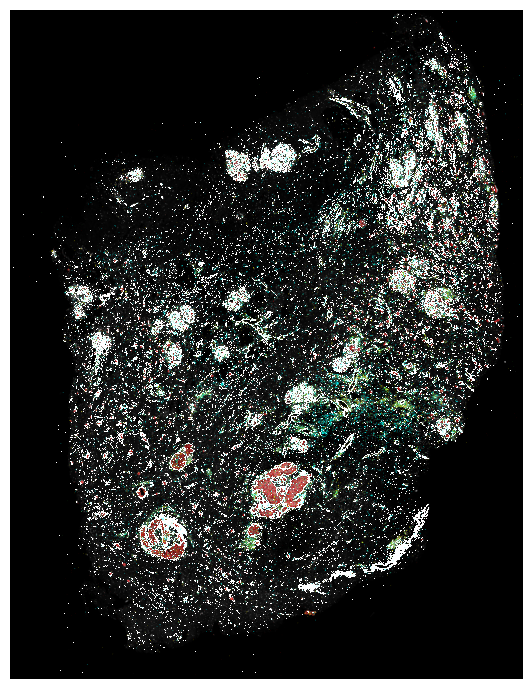

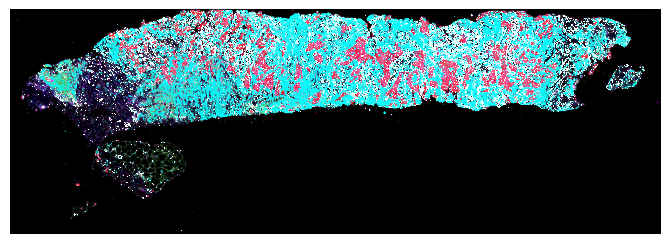

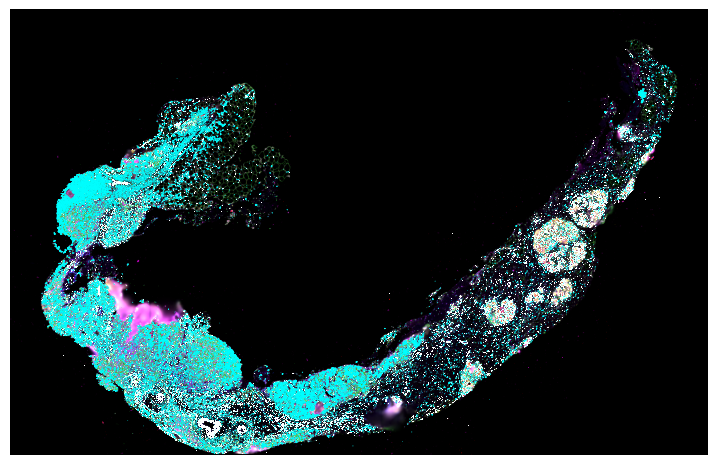

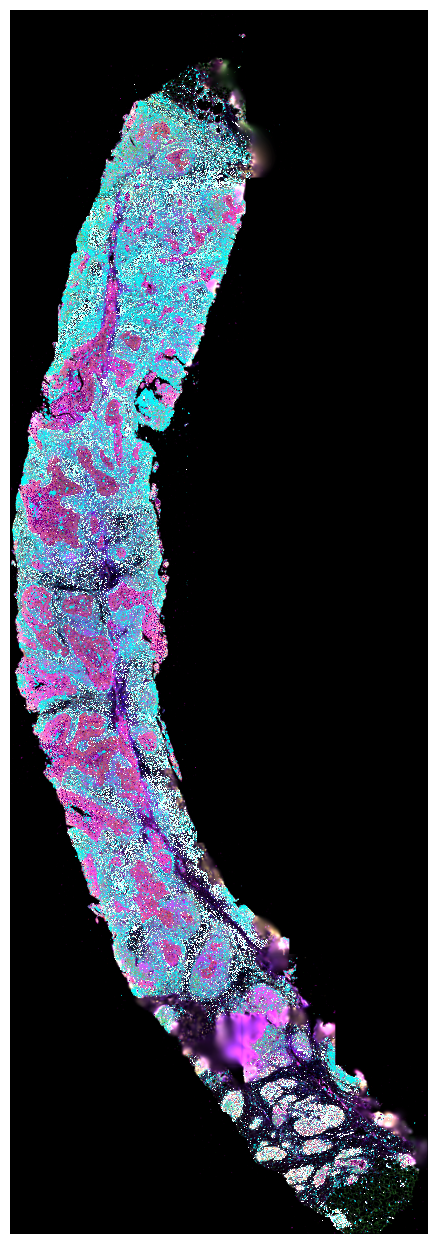

In [10]:
for fp in fps[:]:
    name = fp.split('/')[-1]
    sid = name.split('__')[2]
    print(sid)

    path = Path(fp)
    transcripts_fp = path / 'transcripts.parquet'
    assert transcripts_fp.exists()
    
    
    focus_dir = path / 'morphology_focus'
    if focus_dir.exists():
        names = sorted([name for name in os.listdir(focus_dir) if '.tif' in name])
        if names:
            morph_fp = focus_dir / names[0]
    elif (path / 'morphology_focus.ome.tif').exists():
        morph_fp = path / 'morphology_focus.ome.tif'
    else:
        morph_fp = path / 'morphology.ome.tif'
    assert morph_fp.exists(), f'No morphology file found: {morph_fp}'

    channels, data = multiplex.extract_ome_tiff(morph_fp, as_dict=False)
    focus_res = multiplex.pixels_per_micron(morph_fp) # is actually microns per pixel
    data = utils.rescale(data, scale=focus_res, dim_order='c h w', target_dtype=data.dtype) # 1 mmp
    output_filepath = save_dir / f'{sid}_morphologyfocus.ome.tiff'
    multiplex.write_basic_ome_tiff(
        output_filepath,
        data, channels, microns_per_pixel=1
    )
    del(data)
    
    rgb_vanilla = get_xenium_pseudo(
        morph_fp,
        XENIUM_FOCUS_SETTINGS
    )
    rgb_vanilla = utils.rescale(rgb_vanilla, scale=focus_res, dim_order='h w c', target_dtype=rgb_vanilla.dtype)
    print(rgb_vanilla.shape)
    rgb = add_transcripts_to_rgb(
        rgb_vanilla, transcripts_fp,
        xenium_view_settings
    )
    
    tifffile.imwrite(save_dir / f'{sid}_rgb.tif', rgb, compression='LZW')
    tifffile.imwrite(save_dir / f'{sid}_rgbvanilla.tif', rgb_vanilla, compression='LZW')

    

## region characterization

In [13]:
def generate_labeled_regions(x, cut=10, area=10):
    mask = x > cut

#     mask = scipy.ndimage.binary_fill_holes(mask)

    labeled = skimage.morphology.label(mask)

    props = skimage.measure.regionprops(labeled)
    count = 0
    for p in props:
        if p.area < area:
            labeled[labeled==p.label] = 0
            count += 1
    return labeled

def get_feature_df(labeled, img, channels, channel_info):
    annots = sorted(channel_info.keys())
    data = []
    columns =  channels + annots
    props = skimage.measure.regionprops(labeled, intensity_image=rearrange(img, 'c h w -> h w c'))
    for p in props:
        row = list(p.intensity_mean)
        r1, c1, r2, c2 = p.bbox
        for annot in annots:
            tile = annot_to_mask[annot][r1:r2, c1:c2]
            frac = np.count_nonzero(tile[p.image] > 0) / np.count_nonzero(p.image)
            row.append(frac)
        data.append(row)
    return pd.DataFrame(data=data, columns=columns, index=[p.label for p in props])


In [14]:
def shrink_labels(labeled, distance=1):
    z = distance + 10
    new = labeled.copy()
    props = skimage.measure.regionprops(labeled)
    for p in props:
        r1, c1, r2, c2 = p.bbox
        r1 = max(0, r1 - z)
        c1 = max(0, c1 - z)
        r2 = min(r2 + z, labeled.shape[0])
        c2 = min(c2 + z, labeled.shape[1])
    
        labeled_tile = new[r1:r2, c1:c2]
    
        m = labeled_tile == p.label
        m2 = m.copy()
        for i in range(distance):
            m2 = skimage.morphology.binary_erosion(m2)
    
        new_tile = labeled_tile.copy()
        new_tile[m & ~m2] = 0
    
        new[r1:r2, c1:c2] = new_tile

    return new


    
    

In [33]:
default = {
    'epithelial': ('EPCAM', 1),
    'myoepithelial': ('KRT5', 5),
}

myoepi_channels = [
    'KRT5',
    'KRT7'
]

sid_to_channel_info = {
    
}

In [34]:
tiled_fps = sorted(utils.listfiles(save_dir, regex=r'_tiled.tif$'))
tiled_fps

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT2681-Th1H3L1U2_tiled.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT268B1-Th1H3L1U1_tiled.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT591B1-S1H1Fp1Us1_1_tiled.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT814Z1-S1H1Fp1Us1_3_tiled.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT817Z1-S1H1Fp1Us1_2_tiled.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT832Z1-S1H1Fp1U1_tiled.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT832Z1U1_tiled.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT849Z1-S1H2Fp1U1_tiled.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT852Z1-S1H1Fp1U1_tile

HT2681-Th1H3L1U2


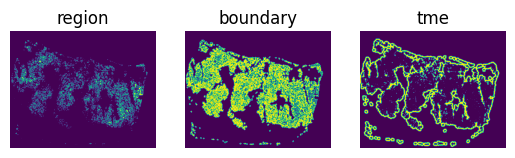

HT268B1-Th1H3L1U1


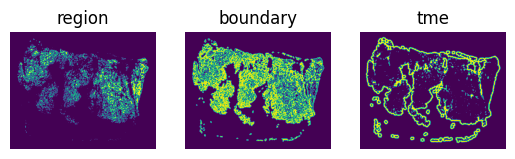

HT591B1-S1H1Fp1Us1_1


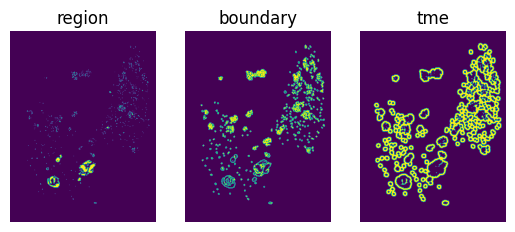

HT814Z1-S1H1Fp1Us1_3


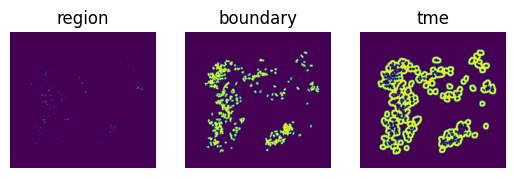

HT817Z1-S1H1Fp1Us1_2


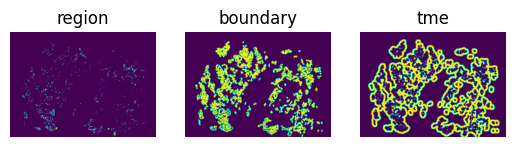

HT832Z1-S1H1Fp1U1


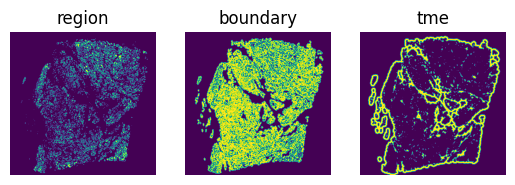

HT832Z1U1


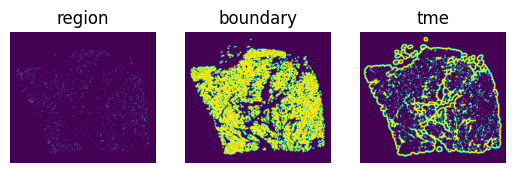

HT849Z1-S1H2Fp1U1


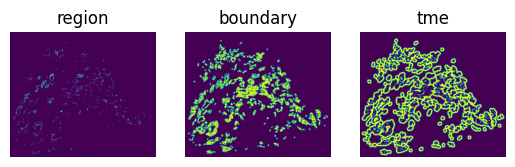

HT852Z1-S1H1Fp1U1


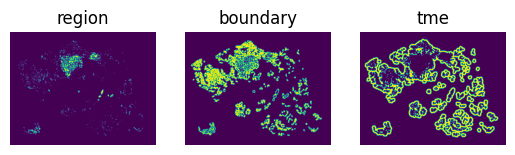

S18-11798-A15Us1_1


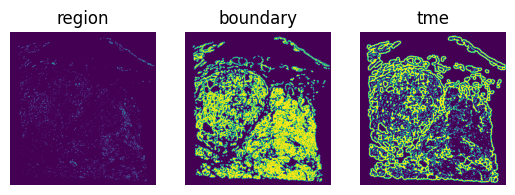

S18-15142-B17Us2_1


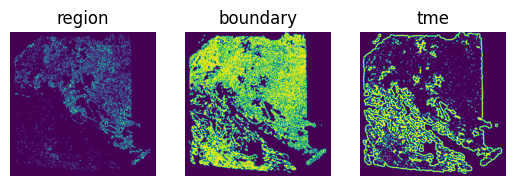

S18-15142Fp1Us1_1


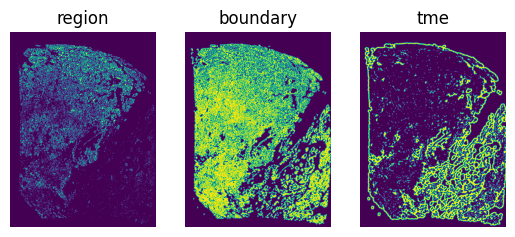

S18-18215-A25Us1_1


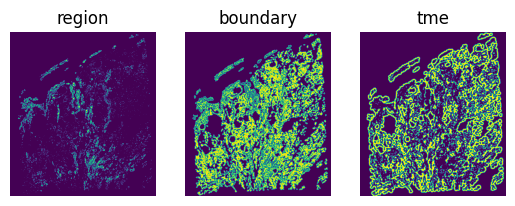

S18-5591-C8Us1_1


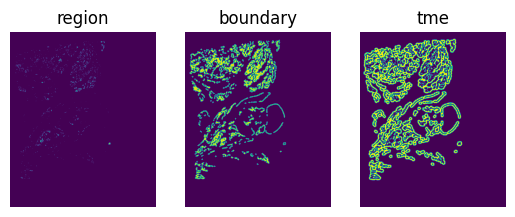

S18-8122-B28U1


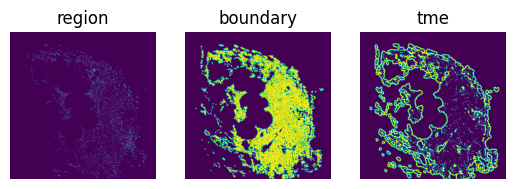

S18-8795-A10Us2_1


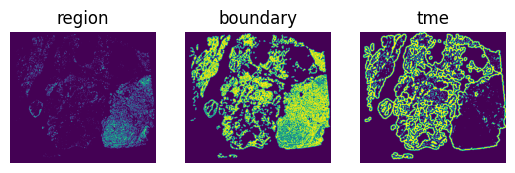

S18-9251-F15U1


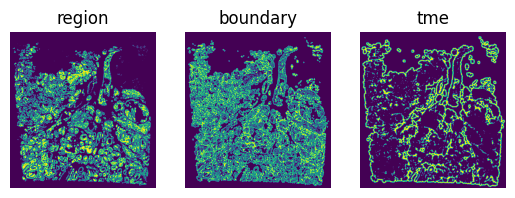

S18-9259-B14U1


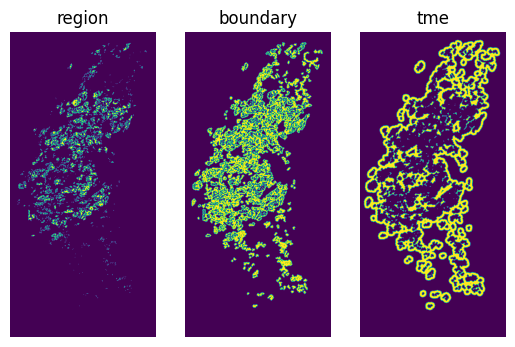

S19-41530-D1U3


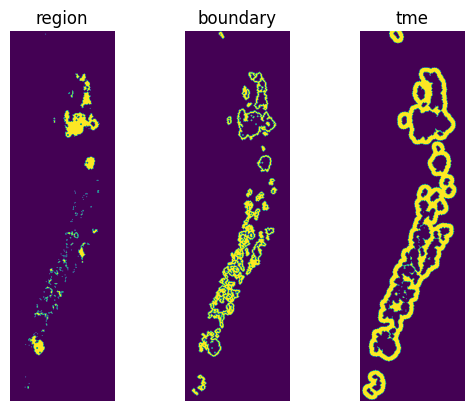

S20-12521-A15U1


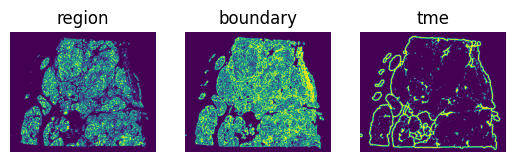

S21-11816-A2U3


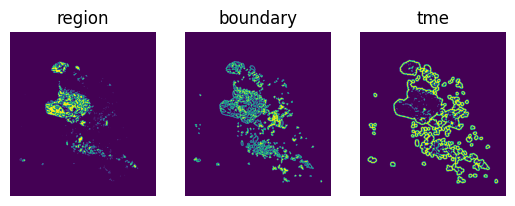

S21-44455-A1U3


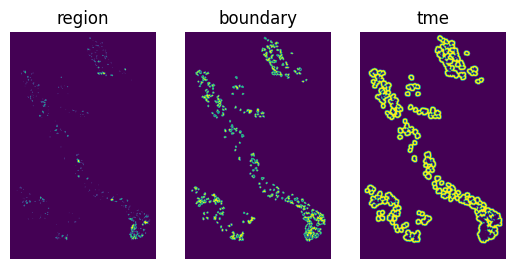

S22-44238-A29U1


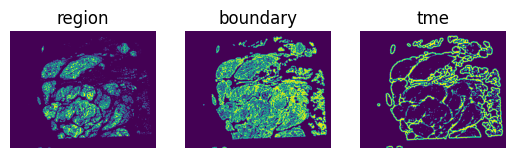

S22-53426-A1U3


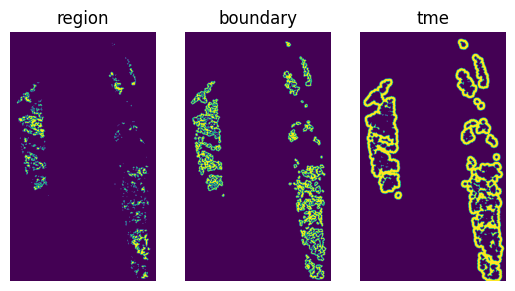

In [35]:
for fp in tiled_fps:
    prefix = fp.replace('_tiled.tif', '')
    sid = prefix.split('/')[-1]
    print(sid)
    
    meta = yaml.safe_load(open(prefix + '_metadata.yaml'))
    channels = meta['channels']
    
    img = tifffile.imread(fp)
    assert len(channels) == img.shape[0]
    
    if sid in sid_to_channel_info:
        channel_info = case_to_channel_info[sid]
    else:
        channel_info = default
        
    if channel_info['myoepithelial'][0] not in channels:
        for c in myoepi_channels:
            if c in channels:
                channel_info['myoepithelial'] = (c, channel_info['myoepithelial'][1])
                break
        
    channel, cut = channel_info['epithelial']

    labeled = generate_labeled_regions(img[channels.index(channel)], cut)
    
    inner = shrink_labels(labeled, distance=1)

    expanded = skimage.segmentation.expand_labels(labeled, distance=2)
    m = (expanded > 0) & ~(inner > 0)
    ring = expanded.copy()
    ring[~m] = 0

    expanded = skimage.segmentation.expand_labels(labeled, distance=10)
    m = (expanded > 0) & ~(skimage.segmentation.expand_labels(labeled, distance=2) > 0)
    tme = expanded.copy()
    tme[~m] = 0
    
    annot_to_mask = {
        k: img[channels.index(info[0])] > info[1] for k, info in channel_info.items()
    }

    fig, axs = plt.subplots(ncols=3)
    stack = []
    for i, (name, x) in enumerate(zip(['region', 'boundary', 'tme'], [inner, ring, tme])):
        df = get_feature_df(x, img, channels, channel_info)
        df.columns = [f'{name}_{c}' for c in df.columns]
        stack.append(df)
        
        ax = axs[i]
        ax.imshow(x > 0)
        ax.set_title(name)
        ax.axis('off')
    plt.show()

    df = pd.concat(stack, axis=1)


    tifffile.imwrite(save_dir / f'{sid}_regions.tif', inner, compression='LZW')
    tifffile.imwrite(save_dir / f'{sid}_boundaries.tif', ring, compression='LZW')
    tifffile.imwrite(save_dir / f'{sid}_tme.tif', tme, compression='LZW')

    df.to_csv(save_dir / f'{sid}_regions.txt.gz', sep='\t')



In [46]:
# /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT2681-Th1H3L1U2_tiled.tif